# TUTORIAL 1
## Principal Component Analysis on MNIST data

### Preliminaries

In [1]:
using LinearAlgebra, Random, Images, Statistics, Plots
include("myJuliaLib/MNIST.jl")  # contains function `MNIST2json`
include("myJuliaLib/readclassjson.jl") # contains function `readclassjson`

readclassjson (generic function with 1 method)

### Convert MNIST binary files to JSON files 

In [2]:
cd(@__DIR__)
isfile("JSON/MNIST_train.json") || MNIST2json()

MNIST_train = readclassjson("JSON/MNIST_train.json")
MNIST_test  = readclassjson("JSON/MNIST_test.json")

Dict{Any, Any} with 2 entries:
  "X" => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  "y" => [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6]

### Embed data by scaling pixel values to appear on the [0,1] interval 

In [3]:
x_train = MNIST_train["X"]/255
x_test  = MNIST_test["X"]/255
y_train = MNIST_train["y"]
y_test  = MNIST_test["y"];

### Visualize randomly chosen entries from the MNIST dataset

In [4]:
# This function display a patch of images randonly chosen from either the training or test data
function display_patches(img, patchSize)
    all_img = reshape(Float64.(ones(28*patchSize + patchSize - 1)), :, 1)
    for j = 1:patchSize
        # Rewrite first_n with next n columns
        first_n = convert(Array, vec(img[(j-1)*patchSize+1:j*patchSize, :]'));  
        for i in 1:patchSize-1
            # place a row of white pixels between consecutive images
            # bang operator (!) mutates original variable
            splice!(first_n, (28^2)*i+1+28*(i-1):(28^2)*i+28*(i-1), Float64.(ones(28)))
        end
        first_n = permutedims(reshape(first_n, 28, :), (2,1))  
        # `reshape` rearranges values in column-major order, whereas image pixels are read in row-major order

        all_img = hcat(all_img, first_n, reshape(Float64.(ones(28*patchSize + patchSize - 1)), :, 1))
    end    
    return imPatch = colorview(Gray, Float16.(all_img))
end

display_patches (generic function with 1 method)

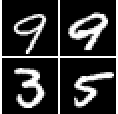

In [5]:
# Display a patch of randomly chosen images from the training set
patchSize = 2
randIndx = randperm(MersenneTwister(737), size(x_train,1))
randIndx = randIndx[1:patchSize^2] 

IM_orig = display_patches(x_train[randIndx, :], patchSize)

### Perform PCA on test images to reduce the number of features

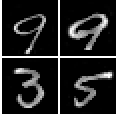

In [6]:
# IMPLEMENT PCA
# Demean the data and perform SVD
x_demean = x_train .- mean(x_train, dims = 1) 
F = svd((x_demean' * x_demean) / size(x_demean, 1))

# # ROTATE DATA AND CHECK ITS COVARIANCE
# # Rotate original data and confirm that its covariance matrix is diagonal by plotting it
xRot = x_demean * F.U
# SigmaRot = (xRot' * xRot) / size(xRot, 1)
# colorview(Gray, Float16.(SigmaRot))

# FIND NUMBER OF COMPONEMTS TO RETAIN
# Find k for which at least 99 percent of the variance is retained
lambdas = cumsum(F.S)/sum(F.S)
k = searchsortedfirst(lambdas, 0.99)

# PCA WITH DIMENSION REDUCTION
xPCA = x_demean * F.U[:,1:k] * F.U[:, 1:k]' 
IM_reducedim = display_patches(xPCA[randIndx, :], patchSize)

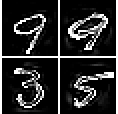

In [7]:
# PCA WITH WHITENING AND REGULARIZATION. CHECK ITS COVARIANCE
epsilon = 0.01
xPCAwhite = x_demean * F.U * diagm(0 => 1 ./ sqrt.(F.S .+ epsilon))
# colorview(Gray, Float16.(xPCAwhite' * xPCAwhite) / size(xPCAwhite, 1))

# ZCA WITH WHITENING AND REGULARIZATION. CHECK ITS COVARIANCE
xZCAwhite = xPCAwhite * F.U'

# Visualize xZCAwhite versus original data
IM_ZCAwhite = display_patches(xZCAwhite[randIndx, :], patchSize)